# Develop cross scatterings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
from importlib import reload

import foscat.scat_cov as sc

import almscat.Sphere_lib as sphlib

2023-02-14 18:00:07.252571: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-14 18:00:07.408169: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-14 18:00:07.408193: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-14 18:00:08.080700: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

# Get data

In [2]:
# DEFINE A PATH FOR scratch data
# The data are stored using a default nside to minimize the needed storage
scratch_path = '../data'
nout = 64  # NSIDE

In [3]:
# Dust
im1 = sphlib.make_hpx_sky(nside=nout, sky_type='dust', normalize=True, nest=True)
im2 = sphlib.make_hpx_sky(nside=nout, sky_type='dust', normalize=True, nest=True)
print(type(im1))
# Planet map
# planet = 'venus'
# im2 = sphlib.make_hpx_planet(nside=nout, planet=planet, interp=True, normalize=True, nest=True)


Mean and STD: -0.000 and 1.000
Mean and STD: -0.000 and 1.000
<class 'numpy.ndarray'>


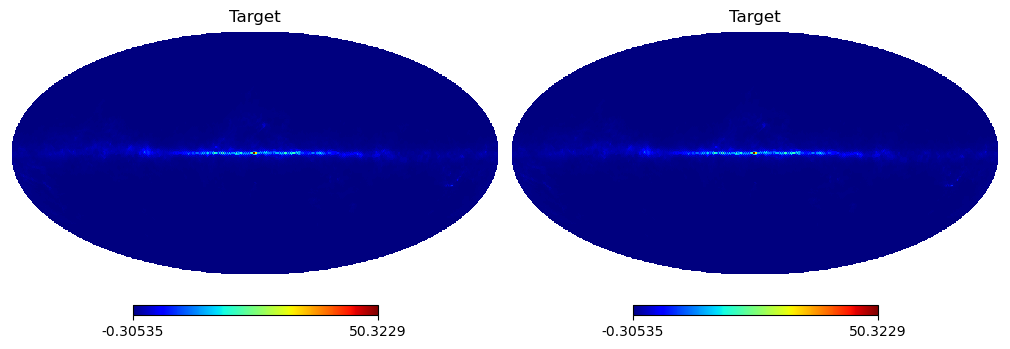

In [4]:
# Plot the healpix map
plt.figure(figsize=(10, 6))
hp.mollview(im1, cmap='jet', nest=True, title='Target', sub=(1, 2, 1))
hp.mollview(im2, cmap='jet', nest=True, title='Target', sub=(1, 2, 2))

# Initialize FOCUS class

In [13]:
reload(sc)
scat_op=sc.funct(NORIENT=3,   # define the number of wavelet orientation
                 KERNELSZ=5,  # define the kernel size (here 5x5)
                 OSTEP=2,     # get very large scale (nside=1)
                 LAMBDA=1.,  # 1 if KERNELSZ=5, 1.2 if KERNELSZ=3
                 TEMPLATE_PATH=scratch_path,
                 use_R_format=False)


          START FOSCAT CONFIGURATION
Num GPUs Available:  0
==                                                        ==
==                                                        ==
==     RUN ON GPU Rank 0 : CPU:0                          ==
==                                                        ==
==                                                        ==


# Normalization to consider

Choose the normalisation you want to consider in the following.

In [14]:
norm = 'auto'  # None, 'self' or 'auto'

# Compute scattering coeffs

Check that the cross of 2 identical images are identical to the auto.

In [15]:
im1 = sphlib.make_hpx_sky(nside=nout, sky_type='dust', normalize=True, nest=True)
im2 = im1

# Auto coeff on image 1
ref1 = scat_op.eval(im1, image2=None, norm=norm)

# Cross coeff on image 1 and 2
scat_op.clean_norm()  # Clean the normalization
refX = scat_op.eval(im1, image2=im2, norm=norm)

S1im1 = ref1.S1.numpy().squeeze()
P00im1 = ref1.P00.numpy().squeeze()
C01im1 = ref1.C01.numpy().squeeze()
C11im1 = ref1.C11.numpy().squeeze()

P00X = refX.P00.numpy().squeeze()
C01X = refX.C01.numpy().squeeze()
C10X = refX.C10.numpy().squeeze()
C11X = refX.C11.numpy().squeeze()

Mean and STD: -0.000 and 1.000


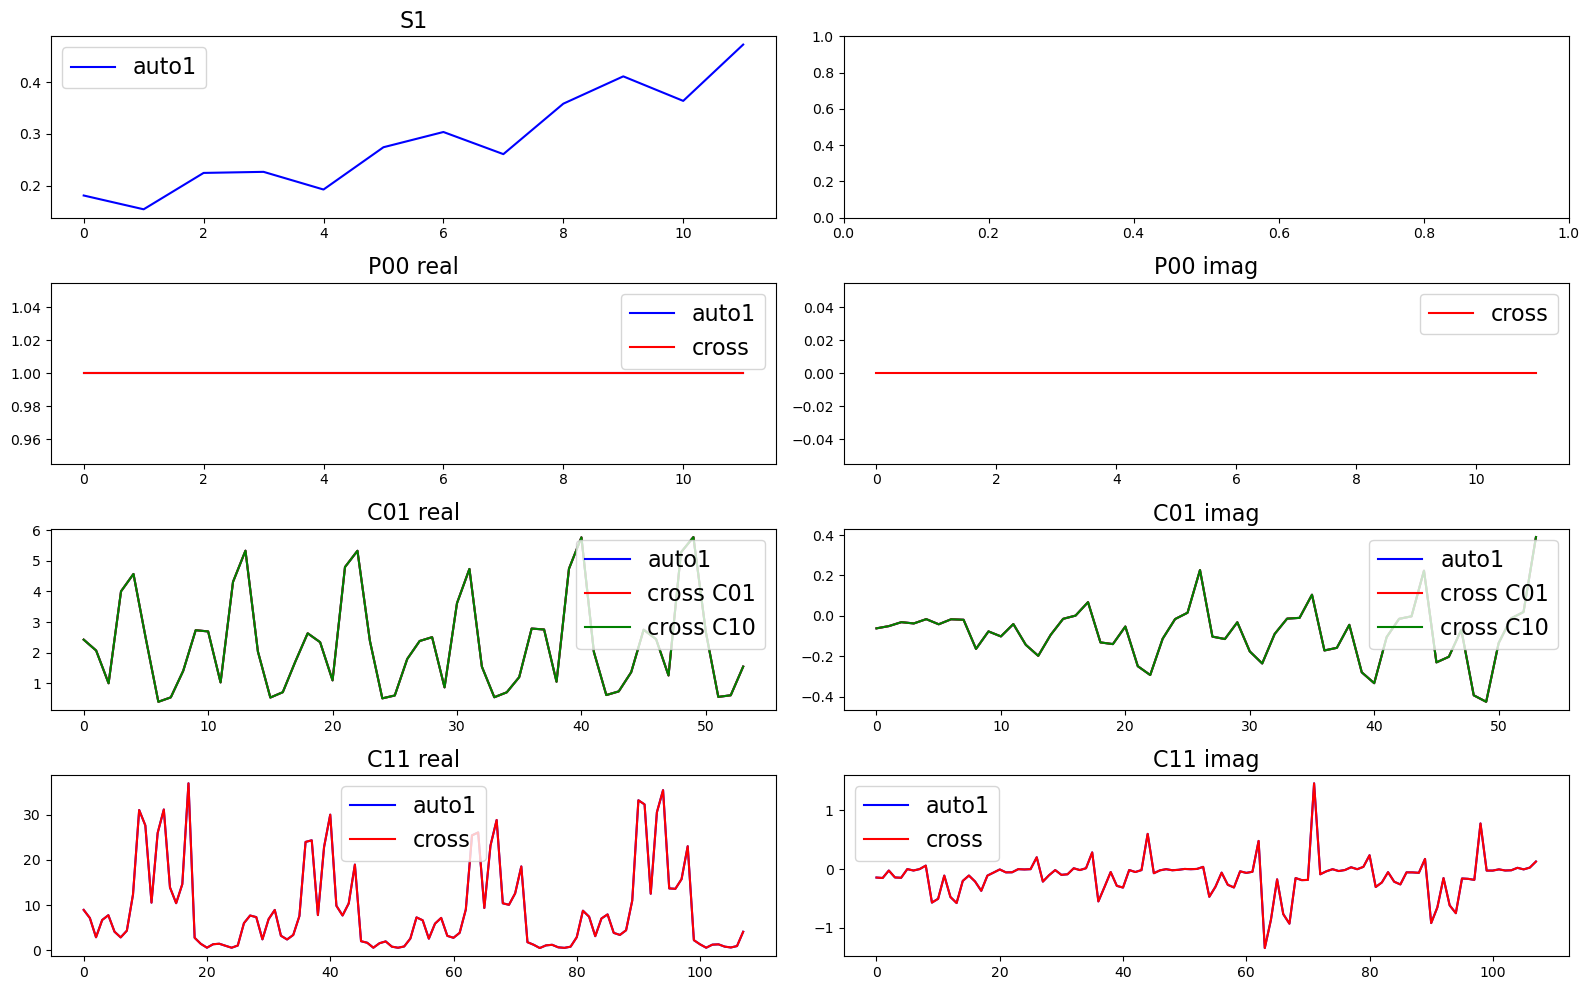

In [17]:
fig, axs = plt.subplots(4, 2, figsize=(16, 10))
axs = axs.ravel()
axs[0].plot(S1im1.flatten(), 'b', label='auto1')
axs[0].set_title('S1', fontsize=16)
axs[0].legend(fontsize=16)

axs[2].plot(P00im1.flatten(), 'b', label='auto1')
axs[2].plot(np.real(P00X).flatten(), 'r', label='cross')
axs[2].set_title('P00 real', fontsize=16)
axs[2].legend(fontsize=16)

axs[3].plot(np.imag(P00X).flatten(), 'r', label='cross')
axs[3].set_title('P00 imag', fontsize=16)
axs[3].legend(fontsize=16)

axs[4].plot(np.real(C01im1).flatten(), 'b', label='auto1')
axs[4].plot(np.real(C01X).flatten(), 'r', label='cross C01')
axs[4].plot(np.real(C10X).flatten(), 'g', label='cross C10')
axs[4].set_title('C01 real', fontsize=16)
axs[4].legend(fontsize=16)

axs[5].plot(np.imag(C01im1).flatten(), 'b', label='auto1')
axs[5].plot(np.imag(C01X).flatten(), 'r', label='cross C01')
axs[5].plot(np.imag(C10X).flatten(), 'g', label='cross C10')
axs[5].set_title('C01 imag', fontsize=16)
axs[5].legend(fontsize=16)

axs[6].plot(np.real(C11im1).flatten(), 'b', label='auto1')
axs[6].plot(np.real(C11X).flatten(), 'r', label='cross')
axs[6].set_title('C11 real', fontsize=16)
axs[6].legend(fontsize=16)

axs[7].plot(np.imag(C11im1).flatten(), 'b', label='auto1')
axs[7].plot(np.imag(C11X).flatten(), 'r', label='cross')
axs[7].set_title('C11 imag', fontsize=16)
axs[7].legend(fontsize=16)

fig.tight_layout()

# Normalisation

We compute cross spectra over two independent noise maps and we repeat this many times to compute the STD over realisations.

In [25]:
P00X_indep, C01X_indep, C10X_indep, C11X_indep = [], [], [], []
nreals = 10
for r in range(nreals):
    # Noise
    noise1 = np.random.randn(12 * nout**2)
    noise2 = np.random.randn(12 * nout**2)

    # Check auto and cross on the same image are equal
    refX = scat_op.eval(noise1, image2=noise2, norm=norm)

    P00X_indep.append(refX.P00.numpy().squeeze())
    C01X_indep.append(refX.C01.numpy().squeeze())
    C10X_indep.append(refX.C10.numpy().squeeze())
    C11X_indep.append(refX.C11.numpy().squeeze())

    # Clean the normalization
    scat_op.clean_norm()

dindep = {'P00X':np.array(P00X_indep),
          'C01X':np.array(C01X_indep),
          'C10X':np.array(C10X_indep),
          'C11X':np.array(C11X_indep)}

In [26]:
dstd_real, dstd_imag = {}, {}
dmean_real, dmean_imag = {}, {}
for key in dindep.keys():
    print(key)
    dstd_real[key] = np.std(np.real(dindep[key]), axis=0)
    dstd_imag[key] = np.std(np.imag(dindep[key]), axis=0)

    dmean_real[key] = np.mean(np.real(dindep[key]), axis=0)
    dmean_imag[key] = np.mean(np.imag(dindep[key]), axis=0)
# print(dstd_real)

P00X
C01X
C10X
C11X


Text(0.5, 1.0, 'Imag')

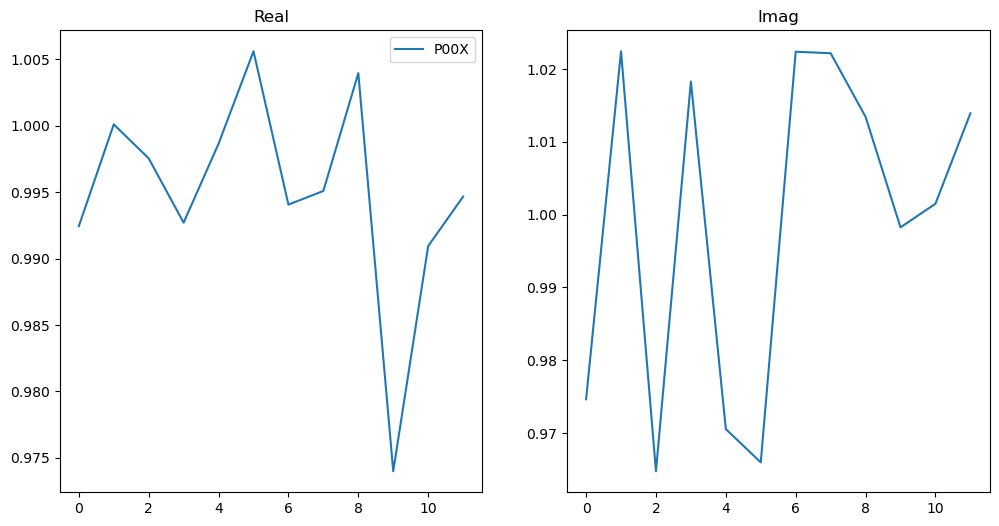

In [27]:
# Plot the mean of C01X and C11X
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax0, ax1 = axs.ravel()
for key in ['P00X']:
    # if key != 'P00X':
    ax0.plot(np.exp(dmean_real[key]).flatten(), label=key)
    ax1.plot(np.exp(dmean_imag[key]).flatten(), label=key)
ax0.set_title('Real')
ax0.legend()

ax1.set_title('Imag')

Text(0.5, 1.0, 'Imag')

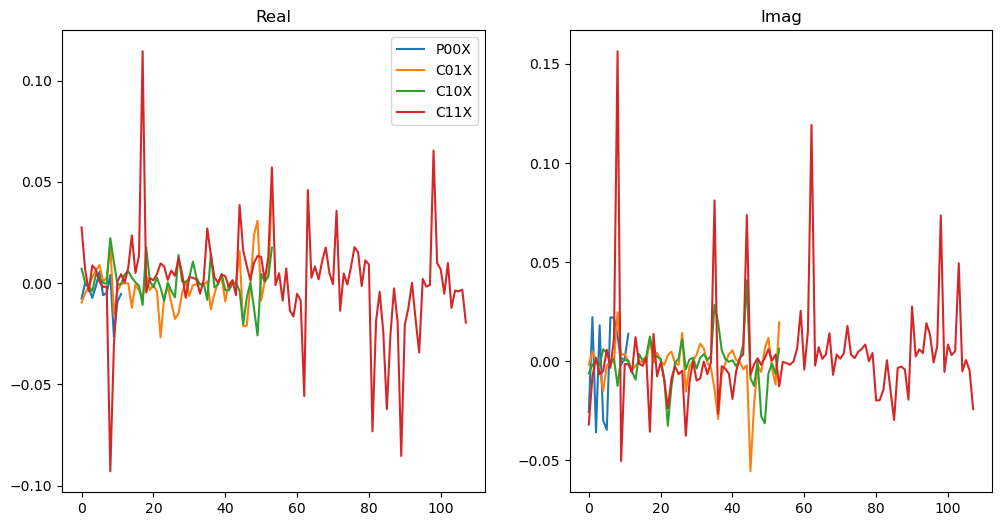

In [28]:
# Plot the mean of C01X and C11X
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
ax0, ax1 = axs.ravel()
for key in dindep.keys():
    # if key != 'P00X':
    ax0.plot(dmean_real[key].flatten(), label=key)
    ax1.plot(dmean_imag[key].flatten(), label=key)
ax0.set_title('Real')
ax0.legend()

ax1.set_title('Imag')

In [29]:
# Compute the cross of two maps and normalize by the STD

# im2 = np.random.randn(12 * nout**2)
im1 = np.random.randn(12 * nout**2)
# im1 = sphlib.make_hpx_sky(nside=nout, sky_type='dust', normalize=True, nest=True)
im2 = sphlib.make_hpx_planet(nside=nout, planet='venus', interp=True, normalize=True, nest=True)

# Compute the cross
scat_op.clean_norm()  # Clean the normalization
refX = scat_op.eval(im1, image2=im2, norm=norm)

# Normalize by the STD
P00X_real = np.real(refX.P00.numpy().squeeze()) / dstd_real['P00X']
C01X_real = np.real(refX.C01.numpy().squeeze()) / dstd_real['C01X']
C10X_real = np.real(refX.C10.numpy().squeeze()) / dstd_real['C10X']
C11X_real = np.real(refX.C11.numpy().squeeze()) / dstd_real['C11X']

P00X_imag = np.imag(refX.P00.numpy().squeeze()) / dstd_imag['P00X']
C01X_imag = np.imag(refX.C01.numpy().squeeze()) / dstd_imag['C01X']
C10X_imag = np.imag(refX.C10.numpy().squeeze()) / dstd_imag['C10X']
C11X_imag = np.imag(refX.C11.numpy().squeeze()) / dstd_imag['C11X']

Mean and STD: -0.000 and 1.000


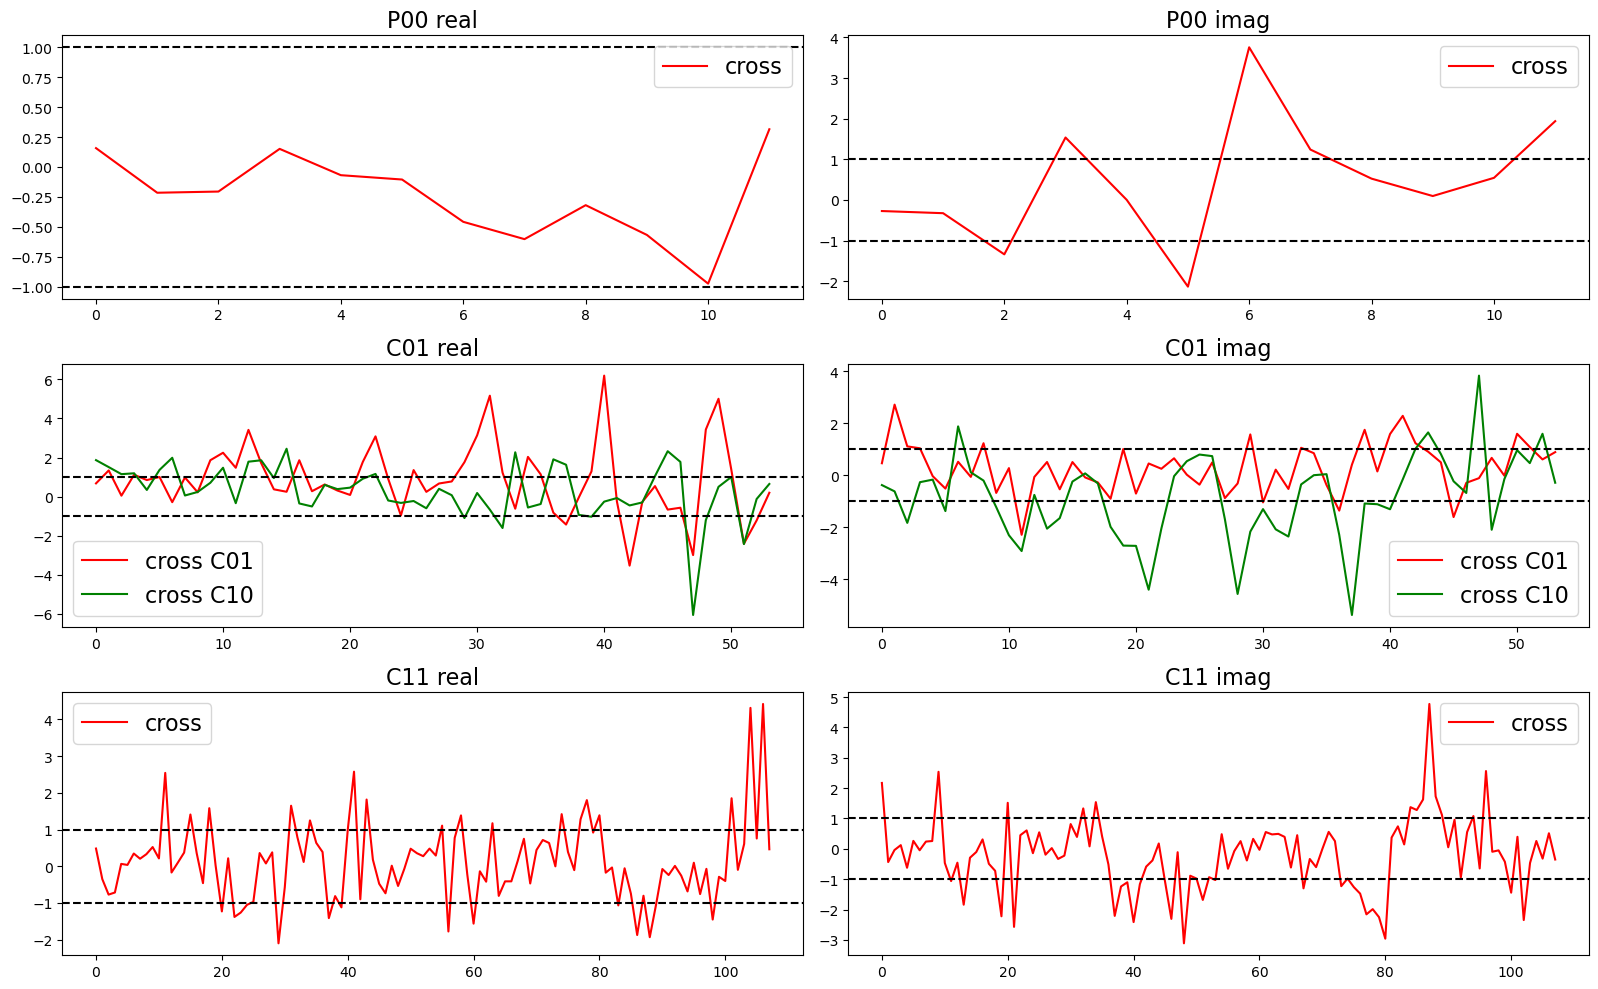

In [30]:
def forplot(ax):
    ax.legend(fontsize=16)
    ax.axhline(-1, color='k', ls='--')
    ax.axhline(1, color='k', ls='--')
    return

fig, axs = plt.subplots(3, 2, figsize=(16, 10))
axs = axs.ravel()

axs[0].plot(P00X_real.flatten(), 'r', label='cross')
axs[0].set_title('P00 real', fontsize=16)
forplot(axs[0])

axs[1].plot(P00X_imag.flatten(), 'r', label='cross')
axs[1].set_title('P00 imag', fontsize=16)
forplot(axs[1])

axs[2].plot(C01X_real.flatten(), 'r', label='cross C01')
axs[2].plot(C10X_real.flatten(), 'g', label='cross C10')
axs[2].set_title('C01 real', fontsize=16)
forplot(axs[2])

axs[3].plot(C01X_imag.flatten(), 'r', label='cross C01')
axs[3].plot(C10X_imag.flatten(), 'g', label='cross C10')
axs[3].set_title('C01 imag', fontsize=16)
forplot(axs[3])

axs[4].plot(C11X_real.flatten(), 'r', label='cross')
axs[4].set_title('C11 real', fontsize=16)
forplot(axs[4])

axs[5].plot(C11X_imag.flatten(), 'r', label='cross')
axs[5].set_title('C11 imag', fontsize=16)
forplot(axs[5])

fig.tight_layout()

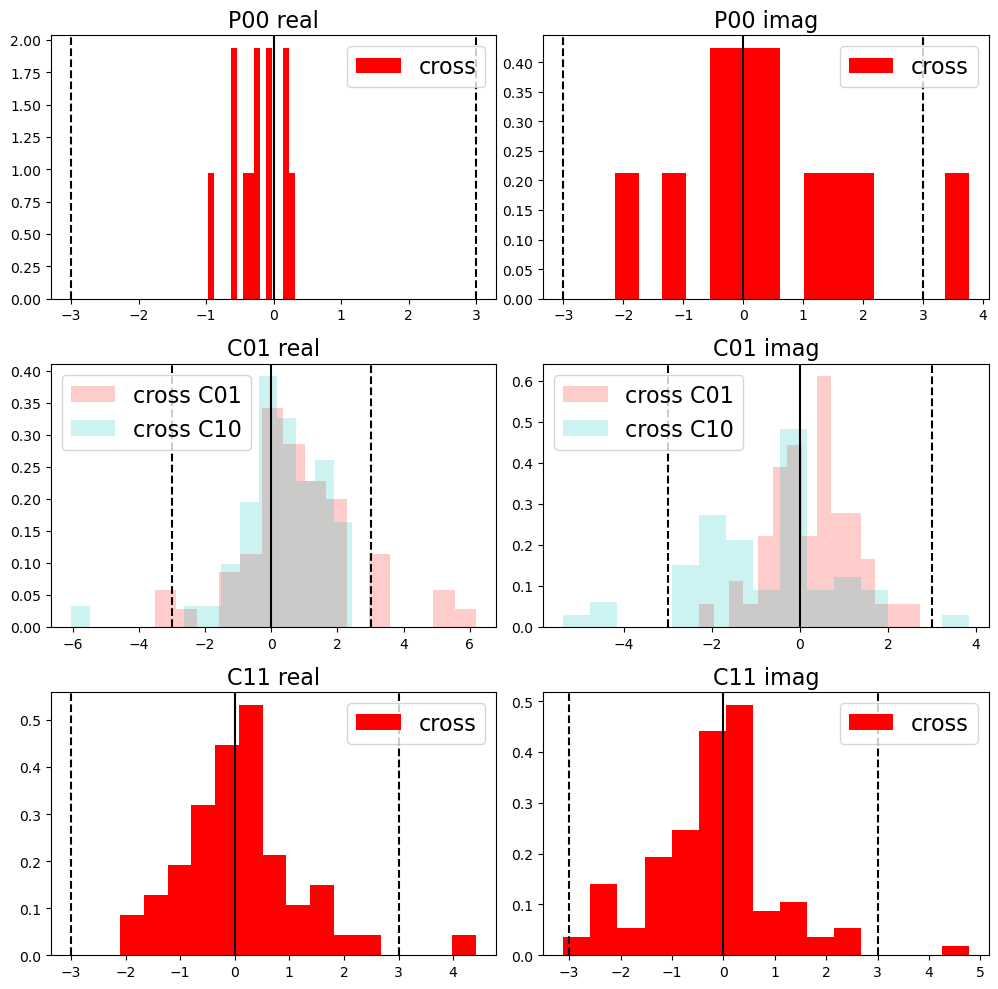

In [31]:
def forhist(ax):
    ax.legend(fontsize=16)
    ax.axvline(-3, color='k', ls='--')
    ax.axvline(0, color='k')
    ax.axvline(3, color='k', ls='--')
    return

fig, axs = plt.subplots(3, 2, figsize=(10, 10))
axs = axs.ravel()

axs[0].hist(P00X_real.flatten(), bins=15, density=True, color='r', label='cross')
axs[0].set_title('P00 real', fontsize=16)
forhist(axs[0])

axs[1].hist(P00X_imag.flatten(), bins=15, density=True, color='r', label='cross')
axs[1].set_title('P00 imag', fontsize=16)
forhist(axs[1])

axs[2].hist(C01X_real.flatten(), bins=15, density=True, color='r', label='cross C01', alpha=0.2)
axs[2].hist(C10X_real.flatten(), bins=15, density=True, color='c', label='cross C10', alpha=0.2)
axs[2].set_title('C01 real', fontsize=16)
forhist(axs[2])

axs[3].hist(C01X_imag.flatten(), bins=15, density=True, color='r', label='cross C01', alpha=0.2)
axs[3].hist(C10X_imag.flatten(), bins=15, density=True, color='c', label='cross C10', alpha=0.2)
axs[3].set_title('C01 imag', fontsize=16)
forhist(axs[3])

axs[4].hist(C11X_real.flatten(), bins=15, density=True, color='r', label='cross')
axs[4].set_title('C11 real', fontsize=16)
forhist(axs[4])

axs[5].hist(C11X_imag.flatten(), bins=15, density=True, color='r', label='cross')
axs[5].set_title('C11 imag', fontsize=16)
forhist(axs[5])

fig.tight_layout()